In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [39]:
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

warnings.filterwarnings('ignore')

# Load the dataset and split into train, validation, and test sets
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [40]:
img_size = 224  # Assuming you want to resize the images to 224x224

def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            # Resize the image while maintaining its aspect ratio
            resized_image = image.resize((img_size, img_size))
            images.append(np.array(resized_image))
            labels.append(label)
    return images, labels

# Load and preprocess the data
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)


In [41]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Expand dimensions for grayscale images
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

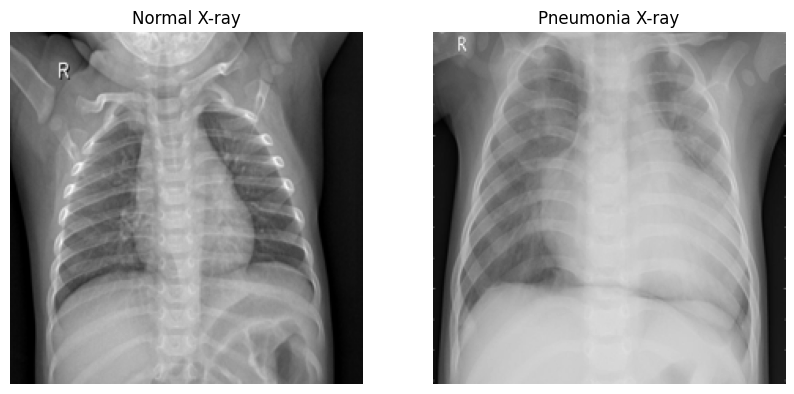

In [42]:
# Choose the desired number of principal components
n_components = 50

# Apply PCA for feature extraction
pca = PCA(n_components=n_components)
X_train_features = pca.fit_transform(X_train_flat)
X_val_features = pca.transform(X_val_flat)
X_test_features = pca.transform(X_test_flat)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Data visualization
# Show examples of normal and pneumonia X-rays
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[y_train == 0][69].squeeze(), cmap='gray')
plt.title('Normal X-ray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train[y_train == 1][96].squeeze(), cmap='gray')
plt.title('Pneumonia X-ray')
plt.axis('off')
plt.show()

In [43]:
# Data augmentation for minority class (normal or 0 class)
normal_X_train = X_train[y_train == 0]
normal_y_train = y_train[y_train == 0]
pneumonia_X_train = X_train[y_train == 1]
pneumonia_y_train = y_train[y_train == 1]

# Upsample minority class
normal_upsampled_X, normal_upsampled_y = resample(normal_X_train, normal_y_train,
                                                  replace=True,
                                                  n_samples=len(pneumonia_X_train),
                                                  random_state=24)

# Combine upsampled minority class with majority class
upsampled_X_train = np.concatenate((normal_upsampled_X, pneumonia_X_train), axis=0)
upsampled_y_train = np.concatenate((normal_upsampled_y, pneumonia_y_train), axis=0)


# Flatten and apply PCA on upsampled data
upsampled_X_train_flat = upsampled_X_train.reshape(upsampled_X_train.shape[0], -1)
upsampled_X_train_features = pca.transform(upsampled_X_train_flat)

In [44]:
upsampled_X_train_features, upsampled_y_train

(array([[ 1.4407532e+01,  4.3134975e+00, -1.5156081e+01, ...,
         -9.0037572e-01, -4.0350854e-03,  9.9650747e-01],
        [-7.9902306e+00, -1.2440896e+01,  5.8491325e-01, ...,
          1.9055536e-01, -7.6449990e-01, -1.2708387e+00],
        [-2.3478361e+01,  3.9500060e+00,  2.6228726e-01, ...,
         -1.5200385e+00, -1.4241561e+00,  9.3187857e-01],
        ...,
        [ 3.1633339e+00, -3.6006904e+00, -3.5448277e+00, ...,
          1.3266813e+00,  5.4191369e-01,  6.0399055e-01],
        [-2.0482742e+01, -1.7379353e+01,  1.2457341e+01, ...,
          9.1237628e-01, -2.4241126e-01,  1.8377408e-02],
        [ 2.3107006e+01,  9.3072863e+00,  8.2224188e+00, ...,
          5.1621169e-01,  1.4729325e+00, -1.3824729e+00]], dtype=float32),
 array([0, 0, 0, ..., 1, 1, 1]))

XGBoost Test Accuracy: 0.780448717948718
XGBoost Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.45      0.61       234
           1       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.73       624
weighted avg       0.82      0.78      0.76       624




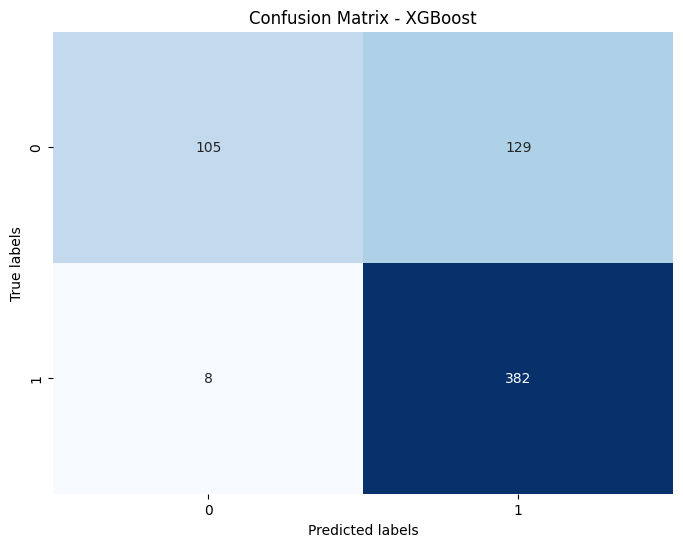

In [45]:
# Initialize XGBoost with best parameters
xgb_best = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                         learning_rate=0.1, max_depth=7, n_estimators=300, random_state=24)

# Train the XGBoost model
xgb_best.fit(upsampled_X_train_features, upsampled_y_train)

# Predictions on test set
y_pred_test = xgb_best.predict(X_test_features)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'XGBoost Test Accuracy: {accuracy_test}')

# Confusion matrix for test set
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

# Classification report for test set
test_classification_rep = classification_report(y_test, y_pred_test)
print(f'XGBoost Test Classification Report:\n{test_classification_rep}\n')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - XGBoost')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()